In [2]:
pip install yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 12.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=317865 sha256=cd00abdfa7e4dc321728386c561e208cc8af065ec03de4e71945768e3c342a8b
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore") 
sns.set_style("darkgrid", {"grid.color": ".6", 
                           "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV

In [17]:
# Define tickers
tickers = ['GC=F', 'CL=F', 'SI=F', 'DX-Y.NYB', '^GSPC', '^IRX']

# Download data
data = yf.download(tickers, start="2015-01-01", end="2024-11-30", interval="1d")

# Keep only the 'Close' prices
data = data['Close']

# Drop rows with missing values
data.dropna(inplace=True)

# Display the data
print(data.head())

[*********************100%***********************]  6 of 6 completed


Ticker           CL=F   DX-Y.NYB         GC=F       SI=F        ^GSPC   ^IRX
Date                                                                        
2015-01-02  52.689999  91.080002  1186.000000  15.734000  2058.199951  0.015
2015-01-05  50.040001  91.379997  1203.900024  16.179001  2020.579956  0.003
2015-01-06  47.930000  91.500000  1219.300049  16.603001  2002.609985  0.020
2015-01-07  48.650002  91.889999  1210.599976  16.510000  2025.900024  0.020
2015-01-08  48.790001  92.370003  1208.400024  16.351000  2062.139893  0.018


In [18]:
data

Ticker,CL=F,DX-Y.NYB,GC=F,SI=F,^GSPC,^IRX
Date,,,,,,
2015-01-02,52.689999,91.080002,1186.000000,15.734000,2058.199951,0.015
2015-01-05,50.040001,91.379997,1203.900024,16.179001,2020.579956,0.003
2015-01-06,47.930000,91.500000,1219.300049,16.603001,2002.609985,0.020
2015-01-07,48.650002,91.889999,1210.599976,16.510000,2025.900024,0.020
2015-01-08,48.790001,92.370003,1208.400024,16.351000,2062.139893,0.018
...,...,...,...,...,...,...
2024-11-22,71.239998,107.489998,2709.899902,31.309000,5969.339844,4.415
2024-11-25,68.940002,106.820000,2616.800049,30.209999,5987.370117,4.405
2024-11-26,68.769997,107.010002,2620.300049,30.388000,6021.629883,4.395


In [19]:
data.isna().sum().sort_values(ascending=False)

Ticker
CL=F        0
DX-Y.NYB    0
GC=F        0
SI=F        0
^GSPC       0
^IRX        0
dtype: int64

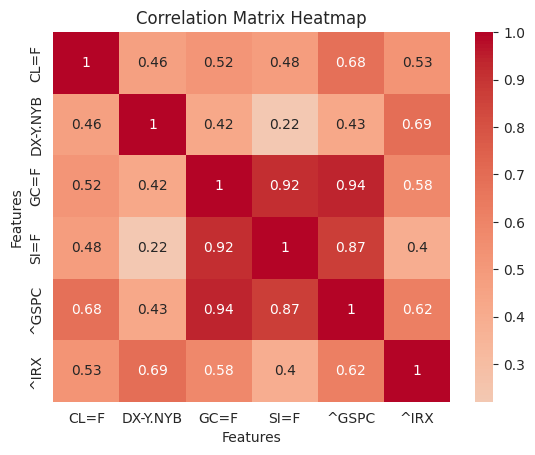

In [20]:
# Calculate correlation matrix
correlation  = data.corr()

# Create heatmap
sns.heatmap(correlation, cmap='coolwarm',
            center=0, annot=True)

# Set title and axis labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

# Show plot
plt.show()

In [23]:
# drop SlV column
data.drop(["^GSPC", "SI=F"], axis=1, inplace=True)

In [24]:
data

Ticker,CL=F,DX-Y.NYB,GC=F,^IRX
Date,,,,
2015-01-02,52.689999,91.080002,1186.000000,0.015
2015-01-05,50.040001,91.379997,1203.900024,0.003
2015-01-06,47.930000,91.500000,1219.300049,0.020
2015-01-07,48.650002,91.889999,1210.599976,0.020
2015-01-08,48.790001,92.370003,1208.400024,0.018
...,...,...,...,...
2024-11-22,71.239998,107.489998,2709.899902,4.415
2024-11-25,68.940002,106.820000,2616.800049,4.405
2024-11-26,68.769997,107.010002,2620.300049,4.395


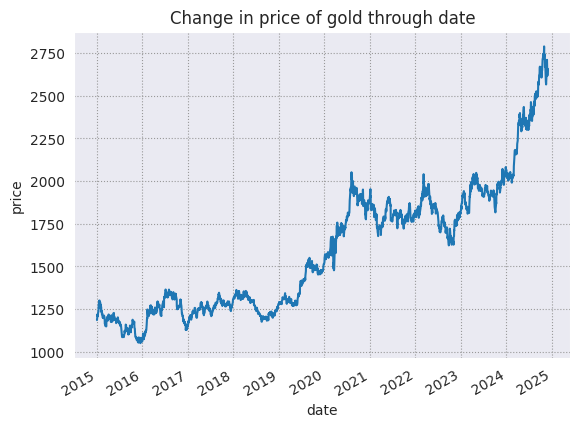

In [27]:
# plot price of gold for each increasing day
data["GC=F"].plot()
plt.title("Change in price of gold through date")
plt.xlabel("date")
plt.ylabel("price")
plt.show()

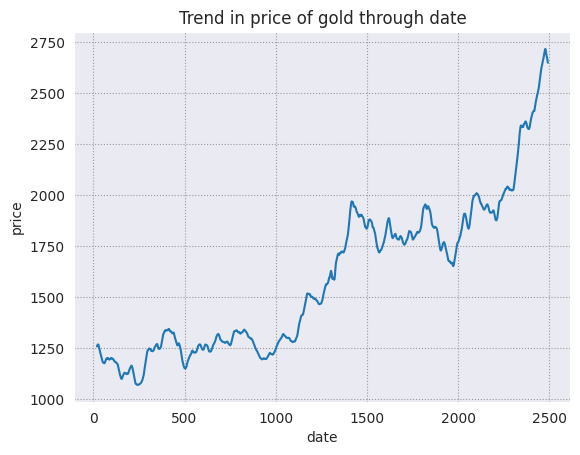

In [29]:
# apply rolling mean with window size of 3
data["price_trend"] = data["GC=F"]\
    .rolling(window=20).mean()

# reset the index to date column
data.reset_index("Date", inplace=True)

# since we have used rolling method
# for 20 rows first 2 rows will be NAN
data["price_trend"].loc[20:].plot()

# set title of the chart
plt.title("Trend in price of gold through date")

# set x_label of the plot
plt.xlabel("date")
plt.ylabel("price")
plt.show()

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2492 non-null   datetime64[ns]
 1   CL=F         2492 non-null   float64       
 2   DX-Y.NYB     2492 non-null   float64       
 3   GC=F         2492 non-null   float64       
 4   ^IRX         2492 non-null   float64       
 5   price_trend  2473 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 116.9 KB


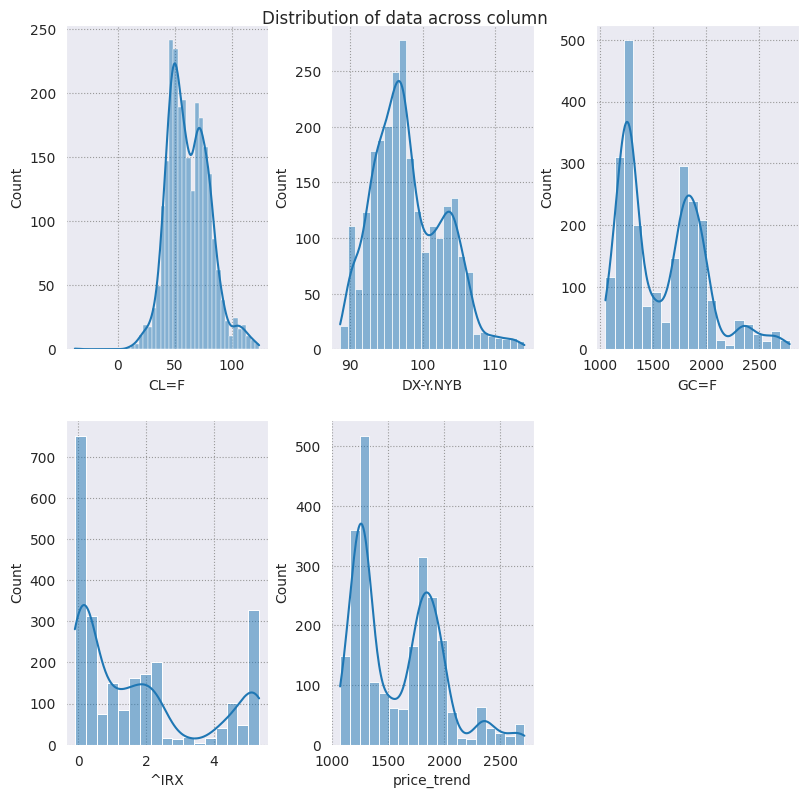

In [32]:
fig = plt.figure(figsize=(8, 8))

# suptitle of the graph
fig.suptitle('Distribution of data across column')
temp = data.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=data, x=item, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [33]:
# skewness along the index axis
print(data.drop("Date", axis=1).skew(axis=0, skipna=True))

Ticker
CL=F           0.378810
DX-Y.NYB       0.512987
GC=F           0.693572
^IRX           0.871342
price_trend    0.664957
dtype: float64


In [36]:
data["^IRX"] = data["^IRX"]\
    .apply(lambda x: np.sqrt(x))

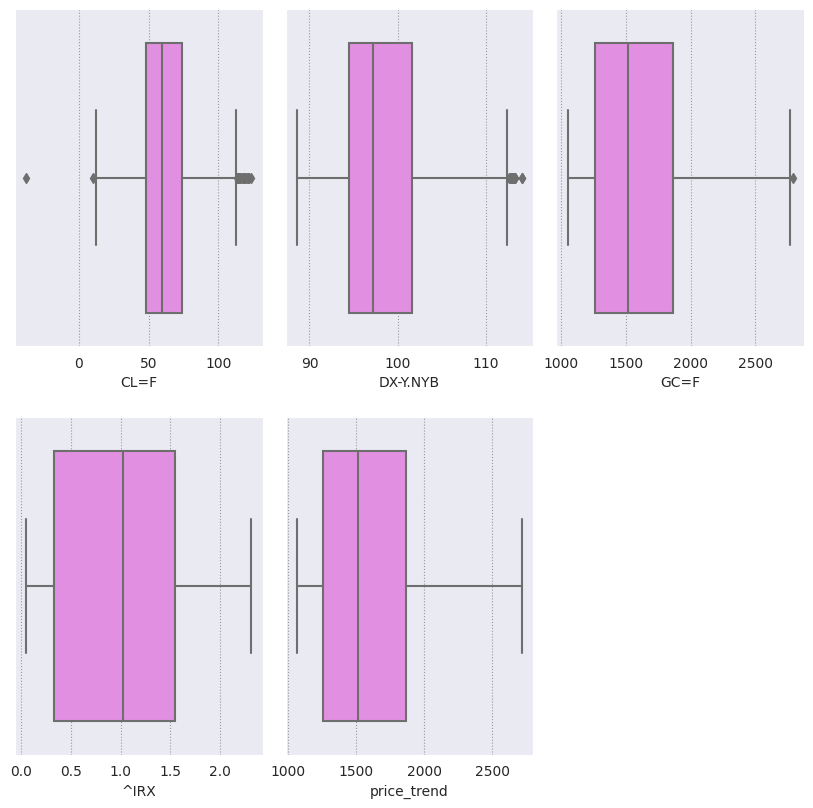

In [37]:
fig = plt.figure(figsize=(8, 8))
temp = data.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=data, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [38]:
def outlier_removal(column):
    # Capping the outlier rows with Percentiles
    upper_limit = column.quantile(.95)
    # set upper limit to 95percentile
    lower_limit = column.quantile(.05)
    # set lower limit to 5 percentile
    column.loc[(column > upper_limit)] = upper_limit
    column.loc[(column < lower_limit)] = lower_limit
    return column

In [39]:
data[['GC=F', 'CL=F', 'DX-Y.NYB', '^IRX']] = \
    data[['GC=F', 'CL=F', 'DX-Y.NYB', '^IRX']].apply(outlier_removal)

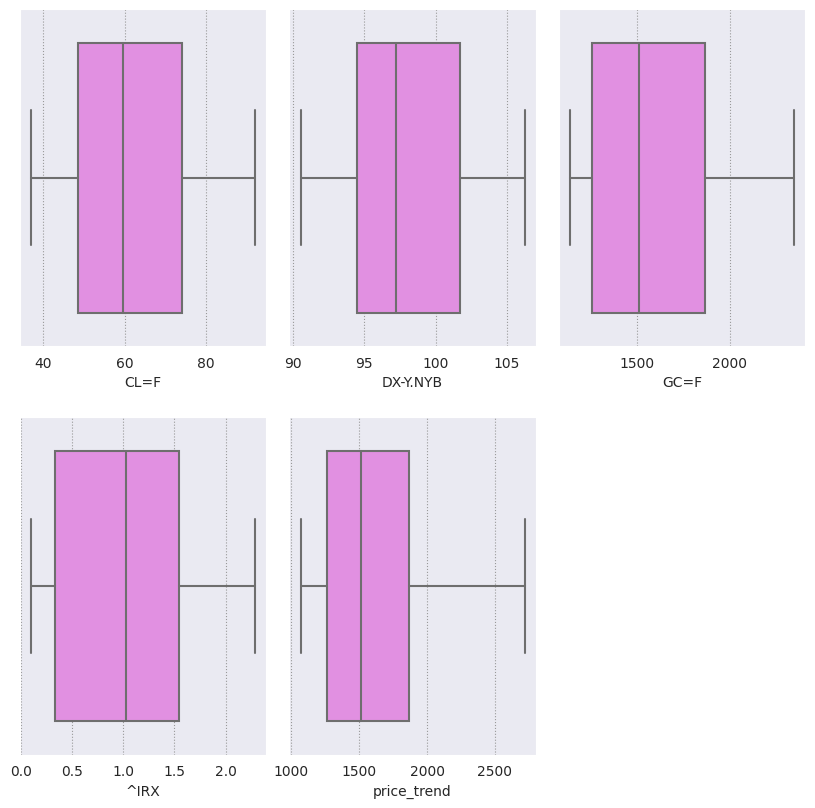

In [40]:
fig = plt.figure(figsize=(8, 8))
temp = data.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=data, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [42]:
X = data.drop(['Date', 'GC=F'], axis=1)

y = data['GC=F']
# dividing dataset in to train test
x_train, x_test,\
    y_train, y_test = train_test_split(X, y,
                                       test_size=0.2)

In [43]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

# Transform the training dataset
# using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [44]:
# Impute missing values using SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # Replace NaNs with the mean of each column

# Fit and transform the imputer on the scaled training data
x_train_scaled = imputer.fit_transform(x_train_scaled)

# Transform the scaled test data using the trained imputer
x_test_scaled = imputer.transform(x_test_scaled)

# Create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)

# Create a Lasso object
lasso = Lasso()

# Define a dictionary of parameter
#values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
                            1e-1, 1, 5, 10, 
                            20, 30, 40]}

# Create a pipeline that first applies 
# polynomial features and then applies Lasso regression
pipeline = make_pipeline(poly, lasso)

# Create a GridSearchCV object with 
#the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline,
                                param_grid, 
                                scoring='r2', cv=3)

# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train)

# Predict the target variable using
# the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_scaled)

# Compute the R-squared of the fitted model on the train data
r2 = r2_score(y_train, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ',
    lasso_grid_search.best_params_)
print('Best score: ',
    lasso_grid_search.best_score_)

R-squared:  0.9824550713759355
Best parameter values:  {'lasso__alpha': 0.1}
Best score:  0.9821406847432312


In [45]:
# Insiate param grid for which to search
param_grid = {'n_estimators': [50, 80, 100],
              'max_depth': [3, 5, 7]}

# create instance of the Randomforest regressor
rf = RandomForestRegressor()

# Define Girdsearch with random forest
# object parameter grid scoring and cv
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)

# Fit the GridSearchCV object to the training data

rf_grid_search.fit(x_train_scaled, y_train)

# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

Best parameter values:  {'max_depth': 7, 'n_estimators': 80}
Best score:  0.9932499250026023


In [46]:
# Compute the R-squared of the
# fitted model on the test data
r2 = r2_score(y_test,
              rf_grid_search.predict(x_test_scaled))

# Print the R-squared
print("R-squared:", r2)

R-squared: 0.9953281360447462


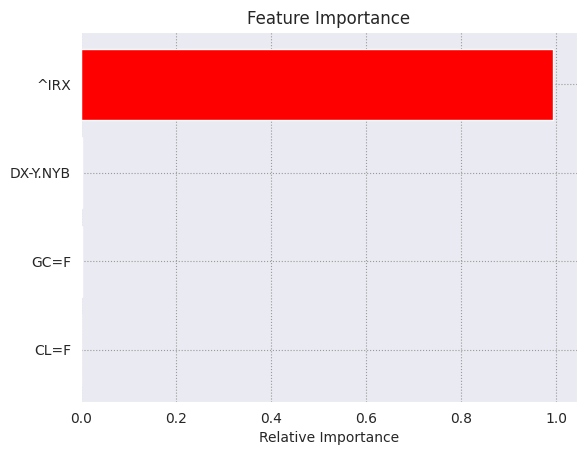

In [47]:
features = data.drop("Date", axis=1).columns

# store the importance of the feature
importances = rf_grid_search.best_estimator_.\
    feature_importances_


indices = np.argsort(importances)

# title of the graph
plt.title('Feature Importance')

plt.barh(range(len(indices)),
         importances[indices],
         color='red',
         align='center')

# plot bar chart
plt.yticks(range(len(indices)),
           [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [48]:
# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(
    y_train, model_xgb.predict(x_train_scaled)))

Xgboost Accuracy = 0.9997668624521167


In [49]:
# Print the R-squared score on the test data
print("Xgboost Accuracy on test data =",
      r2_score(y_test,
               model_xgb.predict(x_test_scaled)))

Xgboost Accuracy on test data = 0.996955410589477


In [50]:
import eli5 as eli
# weight of variables in xgboost model
# Get the names of the features
feature_names = x_train.columns.tolist()

# Explain the weights of the features using ELI5
eli.explain_weights(model_xgb,
                    feature_names=feature_names)

Weight,Feature
0.9911,price_trend
0.0047,DX-Y.NYB
0.0030,^IRX
0.0011,CL=F


In [51]:
# dump model using pickle library
import pickle

# dump model in file model.pkl
pickle.dump(model_xgb, open('model.pkl', 'wb'))